In [121]:
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go




# load dataset (import charging set into data folder first)
charging_set = pd.read_csv("data/cleaned_charging_set_new.csv")
charging_set.head(3)



,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,requestedDeparture_year,requestedDeparture_month,requestedDeparture_day,requestedDeparture_time,requestedDeparture_weekday,connectionDuration,chargingDuration,isRegistered,fullyCharged,parkingDuration
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,...,2020,1,2,20:51:54,3,6.039167,4.378056,1,1,1.66
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,...,2020,1,2,23:31:50,3,9.025278,6.687500,1,1,2.34
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,...,2020,1,2,14:56:35,3,10.713056,2.641944,1,1,8.07


# Hourly number of charging events
Visualized the total and site dependent number of charging events, as a starting point to begin analyzing the development of chargining events. Multiple visualisations were created in order to determine the most suited visualization option.


In [122]:
# calculate amount of charging sessions per day
charging_set['connectionTime_time'] = pd.to_datetime(charging_set['connectionTime_time'])
charging_set['hour'] = charging_set['connectionTime_time'].dt.hour


events_at_day = charging_set.groupby('hour').size().reset_index(name='count')

# count all loading-events over the available timeframe, ploted on hours of the day
fig = px.bar(
    events_at_day,
    x='hour',
    y='count',
    title='Loading-events over the day (siteID = all)',
    labels={'hour': 'Hour', 'count': 'Number of loading-events'}
)

# adjust layout
fig.update_traces(marker_color='#00008B')  # Color
fig.update_layout(
    title_font_size=18,
    legend_title_text="Legend",
    template="plotly_white"
)

# show grafic
fig.show()


for site_id in [1, 2]:
    site_data = charging_set[charging_set['siteID'] == site_id]
    site_events_at_day = site_data.groupby('hour').size().reset_index(name='count')

    # make plot interactive
    fig = px.bar(
        site_events_at_day,
        x='hour',
        y='count',
        title=f'Loading-events over the day (siteID = {site_id})',
        labels={'hour': 'Hour', 'count': 'Number of loading-events'},
    )

    fig.update_traces(marker_color='#1f77b4')

# adjust layout again
    fig.update_layout(
        title_font_size=18,
        legend_title_text="Legend",
        template="plotly_white"
    )

    # show plot 
    fig.show()

### Observation
- Site 1 clearly dominates the total charging numbers. Therefore a visualization which directly compares Site 1 and Site 2 is necessary.

In [123]:

# ensure datetime conversion for connectionTime_time
charging_set['connectionTime_time'] = pd.to_datetime(charging_set['connectionTime_time'])
charging_set['hour'] = charging_set['connectionTime_time'].dt.hour

# function to calculate hourly events combined across sites
def calculate_hourly_events_combined(data):
    hourly_data = []
    for site_id in data['siteID'].unique():
        site_data = data[data['siteID'] == site_id]
        for hour in range(24):
            event_count = len(site_data[site_data['hour'] == hour])
            hourly_data.append({'hour': hour, 'count': event_count, 'siteID': site_id})
    return pd.DataFrame(hourly_data)

# calculate hourly events for all sites combined
hourly_events_combined = calculate_hourly_events_combined(charging_set)

# ensure siteID is treated as a categorical variable
hourly_events_combined['siteID'] = hourly_events_combined['siteID'].astype(str)

# define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# plot combined hourly events with site-specific colors
fig = px.bar(
    hourly_events_combined, x='hour', y='count', color='siteID', 
    title='Loading Events per Hour (Grouped by Site)',
    labels={'hour': 'Hour', 'count': 'Number of Loading Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,  # Apply custom colors
    barmode='group'
)

# update layout for clear legend and x-axis
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white",
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1  # Ensure every hour is displayed on the x-axis
    )
)

fig.show()

In [124]:

# ensure datetime conversion for connectionTime_time
charging_set['connectionTime_time'] = pd.to_datetime(charging_set['connectionTime_time'])
charging_set['hour'] = charging_set['connectionTime_time'].dt.hour

# function to calculate hourly events combined across sites
def calculate_hourly_events_combined(data):
    hourly_data = []
    for site_id in data['siteID'].unique():
        site_data = data[data['siteID'] == site_id]
        for hour in range(24):
            event_count = len(site_data[site_data['hour'] == hour])
            hourly_data.append({'hour': hour, 'count': event_count, 'siteID': site_id})
    return pd.DataFrame(hourly_data)

# calculate hourly events for all sites combined
hourly_events_combined = calculate_hourly_events_combined(charging_set)

# ensure siteID is treated as a categorical variable
hourly_events_combined['siteID'] = hourly_events_combined['siteID'].astype(str)

# calculate total events per hour (site 1 + site 2)
total_events = hourly_events_combined.groupby('hour')['count'].sum().reset_index()

# define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# plot combined hourly events with site-specific colors
fig = px.bar(
    hourly_events_combined, x='hour', y='count', color='siteID', 
    title='Loading Events per Hour (Grouped by Site)',
    labels={'hour': 'Hour', 'count': 'Number of Loading Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,  # Apply custom colors
    barmode='group'
)

# add total events as an orange line
fig.add_trace(
    go.Scatter(
        x=total_events['hour'], 
        y=total_events['count'], 
        mode='lines+markers', 
        name='Total Events',
        line=dict(color='orange', width=2)
    )
)

# update layout for clear legend and x-axis
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white",
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1  # ensure every hour is displayed on the x-axis
    )
)

fig.show()

## Further Observations:
- Site 1 significantly dominates the total numbers
- Total charging events peak at 14:00 with 7061 events
- Minimum is reached at 9:00 with 25 events
- Site 2 peaks 2 hours later than total peak (16:00)

## More Visualizations
In order to attain a broader picture of the hourly development, also the active charging events per hour are visualized

In [125]:
# convert datetime columns
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])
charging_set['disconnectTime'] = pd.to_datetime(charging_set['disconnectTime'])

# function to calculate active events per hour
def calculate_hourly_activity(data, site_id=None):
    if site_id is not None:
        data = data[data['siteID'] == site_id]
    return pd.DataFrame([
        {'hour': hour, 'count': len(data[
            (data['connectionTime'].dt.hour <= hour) & 
            (data['disconnectTime'].dt.hour >= hour)
        ])} for hour in range(24)
    ])

# plot function
def plot_activity(activity_df, title, color='#00008B'):
    fig = px.bar(
        activity_df, x='hour', y='count', title=title, 
        labels={'hour': 'Hour', 'count': 'Active Charging Events'}
    )
    fig.update_traces(marker_color=color)
    fig.update_layout(title_font_size=18, legend_title_text="Legend", template="plotly_white")
    fig.show()

# overall activity
hourly_activity = calculate_hourly_activity(charging_set)
plot_activity(hourly_activity, 'Active Charging Events per Hour (siteID = all)')

# activity per site
for site_id in [1, 2]:
    site_activity = calculate_hourly_activity(charging_set, site_id)
    plot_activity(site_activity, f'Active Charging Events per Hour (siteID = {site_id})', color='#1f77b4')


## Adjustment
As expected total active charging events are also dominated by site 1. This necessitates a differentiation of sites within one visualization.

In [126]:
def calculate_hourly_activity_combined(data):
    hourly_data = []
    for site_id in data['siteID'].unique():
        site_data = data[data['siteID'] == site_id]
        for hour in range(24):
            active_count = len(site_data[(site_data['connectionTime'].dt.hour <= hour) & (site_data['disconnectTime'].dt.hour >= hour)])
            hourly_data.append({'hour': hour, 'count': active_count, 'siteID': site_id})
    return pd.DataFrame(hourly_data)

# calculate activity for both sites combined
hourly_activity_combined = calculate_hourly_activity_combined(charging_set)

# ensure siteID is treated as a categorical variable
hourly_activity_combined['siteID'] = hourly_activity_combined['siteID'].astype(str)

# calculate total active events per hour (site 1 + site 2)
total_activity = hourly_activity_combined.groupby('hour')['count'].sum().reset_index()

# define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# plot with different colors for each site
fig = px.bar(
    hourly_activity_combined, x='hour', y='count', color='siteID', 
    title='Active Charging Events per Hour (Grouped by Site)',
    labels={'hour': 'Hour', 'count': 'Active Charging Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,  # Apply custom colors
    barmode='group'
)

# add total active events as an orange line
fig.add_trace(
    go.Scatter(
        x=total_activity['hour'], 
        y=total_activity['count'], 
        mode='lines+markers', 
        name='Total Active Events',
        line=dict(color='orange', width=2)
    )
)

# update layout for clear legend and x-axis
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white",
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1  # ensure every hour is displayed on the x-axis
    )
)

fig.show()

## Observation
- The peak duration is much longer and constant compared to the previous visualization
- Peaking period: 13:00 - 23:00

# New visualization: Total charging events distributed over the months
This visualization is done to identify any seasonal trends or patterns

In [127]:
# aggregation on months
month_names = {
    1: "January", 2: "February", 3: "March", 4: "April", 
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

events_per_month = charging_set.groupby('connectionTime_month').size().reset_index(name='count')

# add month names
events_per_month['month_name'] = events_per_month['connectionTime_month'].map(month_names)

# count all loading-events over the available timeframe, ploted on hours of the day
fig = px.bar(
    events_per_month,
    x='month_name',
    y='count',
    title='Loading-events per month (sideID = all)',
    labels={'hour': 'Month', 'count': 'Number of loading-events'}
)

# adjust layout 
fig.update_traces(marker_color='#FF8C00')  # Color
fig.update_layout(
    title_font_size=18,
    legend_title_text="Legend",
    template="plotly_white"
)

# plot
fig.show()



## Observation
- Rather constant development
- Peak in January
- Minimum in September

## Adjustment
Differentiate between site 1 and site 2

In [128]:
# aggregation on months
month_names = {
    1: "January", 2: "February", 3: "March", 4: "April", 
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

# group by month and site
events_per_month = charging_set.groupby(['connectionTime_month', 'siteID']).size().reset_index(name='count')

# add month names
events_per_month['month_name'] = events_per_month['connectionTime_month'].map(month_names)

# calculate total events per month by adding site 1 and site 2
total_events_per_month = events_per_month.groupby('connectionTime_month')['count'].sum().reset_index()
total_events_per_month['month_name'] = total_events_per_month['connectionTime_month'].map(month_names)

# ensure siteID is treated as a categorical variable
events_per_month['siteID'] = events_per_month['siteID'].astype(str)

# define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# plot events per site with grouped bars
fig = px.bar(
    events_per_month, 
    x='month_name', 
    y='count', 
    color='siteID',
    title='Loading Events per Month (Grouped by Site)',
    labels={'month_name': 'Month', 'count': 'Number of Loading Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,
    barmode='group'
)

# add total events as an orange line
import plotly.graph_objects as go
fig.add_trace(
    go.Scatter(
        x=total_events_per_month['month_name'], 
        y=total_events_per_month['count'], 
        mode='lines+markers', 
        name='Total Loading Events',
        line=dict(color='orange', width=2)
    )
)

# layout adjustment
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white"
)

# plot
fig.show()

## Observation
- Site 2 dominates in Summer Months most likely due to increased tourism



## Adjustment
- Choosing a different visualization option, to better display peaks

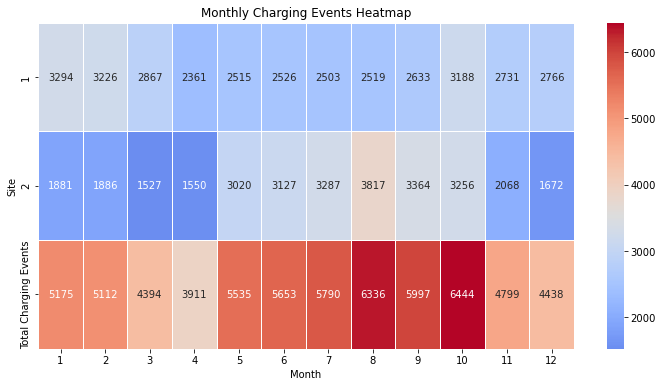

In [129]:
# aggregation on months name
month_names = {
    1: "January", 2: "February", 3: "March", 4: "April", 
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

# group by month and site
events_per_month = charging_set.groupby(['connectionTime_month', 'siteID']).size().reset_index(name='count')

# add months name
events_per_month['month_name'] = events_per_month['connectionTime_month'].map(month_names)

# calculate charging events per month
total_events_per_month = events_per_month.groupby('connectionTime_month')['count'].sum().reset_index()
total_events_per_month['month_name'] = total_events_per_month['connectionTime_month'].map(month_names)
total_events_per_month['siteID'] = 'Total Charging Events'

# prepare heatmap data
df_pivot = events_per_month.pivot(index='siteID', columns='connectionTime_month', values='count').fillna(0)
df_pivot = pd.concat([df_pivot, total_events_per_month.pivot(index='siteID', columns='connectionTime_month', values='count')])

# sort columns
df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

# create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_pivot, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".0f", center=df_pivot.mean().mean())

# titles
plt.title("Monthly Charging Events Heatmap")
plt.xlabel("Month")
plt.ylabel("Site")

# plot
plt.show()

## Observations
- Site 1 dominates
- Clear peaks in January and February

## Adjustment
Now we visualize the number of total charging events over all months of the timespan to identify any other trends or patterns or significant periods

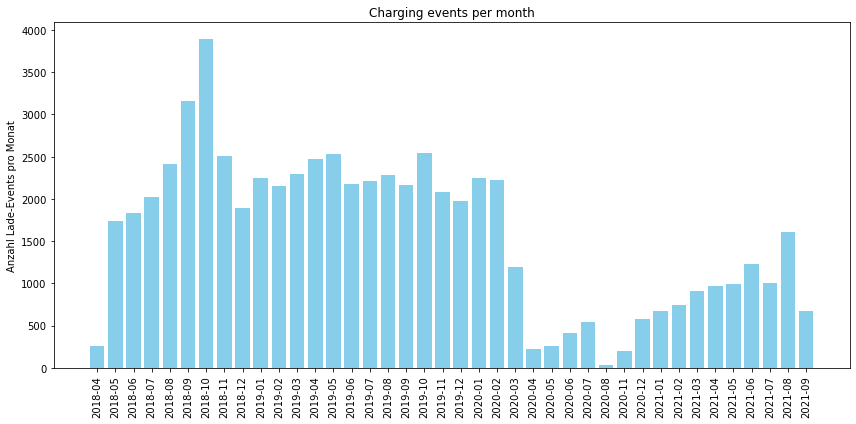

In [130]:
# calculate avg temperature for year and month
avg_temperatures = charging_set.groupby(['connectionTime_year','connectionTime_month']).size().reset_index(name='count')

# create bar chart
plt.figure(figsize=(12, 6))
# combine year and month for x-axix 
avg_temperatures['year_month'] = avg_temperatures['connectionTime_year'].astype(str) + '-' + avg_temperatures['connectionTime_month'].astype(str).str.zfill(2)

# plot barchart 
plt.bar(avg_temperatures['year_month'], avg_temperatures['count'], color='skyblue')

# title 
plt.title('Charging events per month')
plt.xlabel('')
plt.ylabel('Anzahl Lade-Events pro Monat')

# rotate axix
plt.xticks(rotation=90)

# set layout 
plt.tight_layout()

# plot
plt.show()

## Observation
- Generally volatile development
- Peaking period from May 2018 until February 2020
- Abrupt decrease beginning March 2020
- Total charging numbers do not fully recover from this point on

## Adjustment
Once again differentiate between sites to better understand development

In [131]:
# group by year, month and site 
charge_event_count = charging_set.groupby(['connectionTime_year', 'connectionTime_month', 'siteID']).size().reset_index(name='count')

# combine year and month for x-axis
charge_event_count['year_connectionTime_month'] = charge_event_count['connectionTime_year'].astype(str) + '-' + charge_event_count['connectionTime_month'].astype(str).str.zfill(2)

# count total charge events
total_charge_events = charge_event_count.groupby('year_connectionTime_month', as_index=False)['count'].sum()

# ensure siteID is treated as a categorical variable
charge_event_count['siteID'] = charge_event_count['siteID'].astype(str)

# define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# plot events per site with grouped bars
fig = px.bar(
    charge_event_count, 
    x='year_connectionTime_month', 
    y='count', 
    color='siteID',
    title='Charging Events per connectionTime_month (Grouped by Site)',
    labels={'year_connectionTime_month': 'Year-connectionTime_month', 'count': 'Number of Charging Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,
    barmode='group'
)

# add total events as an orange line
fig.add_trace(
    go.Scatter(
        x=total_charge_events['year_connectionTime_month'], 
        y=total_charge_events['count'], 
        mode='lines+markers', 
        name='Total Charging Events',
        line=dict(color='orange', width=2)
    )
)

# adjust layout
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white",
    xaxis=dict(tickangle=90)
)

# plot
fig.show()

## Observation
- Site 1 has no records until October 2018
- Considering the entire timeframe the sites are overall more balanced in terms of their numbers

# New Visualization: Distribution over weekdays
Visualizing the total charging numbers over the weekdays to identify patterns or trends happening on the weekly basis

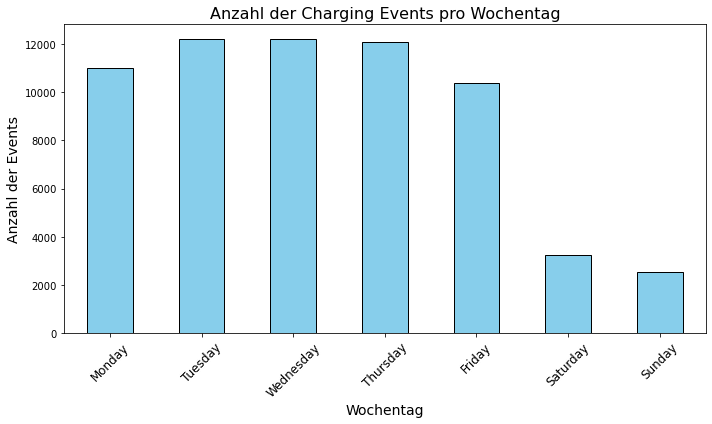

In [132]:
# convert to dt
charging_set['connection_date'] = pd.to_datetime(charging_set['connectionTime'])

# get weekday
charging_set['weekday'] = charging_set['connection_date'].dt.day_name()

# count events per weekday
weekday_counts = charging_set['weekday'].value_counts()

# sort weekday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(weekday_order)

# create plot
plt.figure(figsize=(10, 6))
weekday_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Anzahl der Charging Events pro Wochentag', fontsize=16)
plt.xlabel('Wochentag', fontsize=14)
plt.ylabel('Anzahl der Events', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# plot
plt.show()


## Adjustment
We visualize over the weekdays and further differentiate between sites in order to identify which site is public and which site is private.

In [133]:
# group by weekday and site
weekday_counts = charging_set.groupby(['weekday', 'siteID']).size().reset_index(name='count')

# sort weekday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts['weekday'] = pd.Categorical(weekday_counts['weekday'], categories=weekday_order, ordered=True)
weekday_counts = weekday_counts.sort_values('weekday')

# calculate total weekdays
total_weekday_counts = weekday_counts.groupby('weekday')['count'].sum().reset_index()

# ensure siteID is treated as a categorical variable
weekday_counts['siteID'] = weekday_counts['siteID'].astype(str)

# define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# plot events per site with grouped bars
fig = px.bar(
    weekday_counts, 
    x='weekday', 
    y='count', 
    color='siteID',
    title='Charging Events per Weekday (Grouped by Site)',
    labels={'weekday': 'Weekday', 'count': 'Number of Charging Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,
    barmode='group'
)

# add total events as an orange line
fig.add_trace(
    go.Scatter(
        x=total_weekday_counts['weekday'], 
        y=total_weekday_counts['count'], 
        mode='lines+markers', 
        name='Total Charging Events',
        line=dict(color='orange', width=2)
    )
)

# adjust layout
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white"
)

# plot
fig.show()

## Obersvations
- Site 1 shows higher charging numbers during workdays
- Site 2 shows higher charging numbers at the weekend
- This solidifies the assumption that site 1 is public, since naturally work is usually performed during the workdays

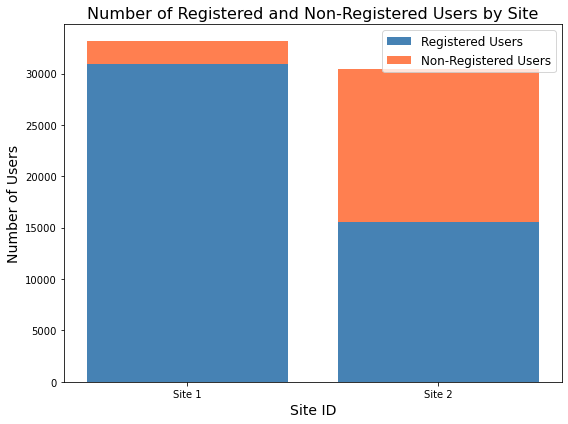

In [134]:

# filter for site 1 and site 2
site_data = charging_set[charging_set['siteID'].isin([1, 2])]

# group by and count site id and isRegistered
site_user_counts = site_data.groupby(['siteID', 'isRegistered']).size().unstack(fill_value=0)

# prepate data
site_ids = site_user_counts.index
registered_counts = site_user_counts[1]  # Registrierte Benutzer
non_registered_counts = site_user_counts[0] if 0 in site_user_counts.columns else [0] * len(site_ids)  # Nicht registrierte Benutzer

# create plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(site_ids, registered_counts, label='Registered Users', color='#4682B4')
ax.bar(site_ids, non_registered_counts, bottom=registered_counts, label='Non-Registered Users', color='#FF7F50')

# titles and labels
ax.set_xlabel('Site ID', fontsize=14)
ax.set_ylabel('Number of Users', fontsize=14)
ax.set_title('Number of Registered and Non-Registered Users by Site', fontsize=16)

# legend and ticks 
ax.set_xticks(site_ids)
ax.set_xticklabels([f'Site {int(site)}' for site in site_ids])
ax.legend(fontsize=12)

# plot
plt.tight_layout()
plt.show()

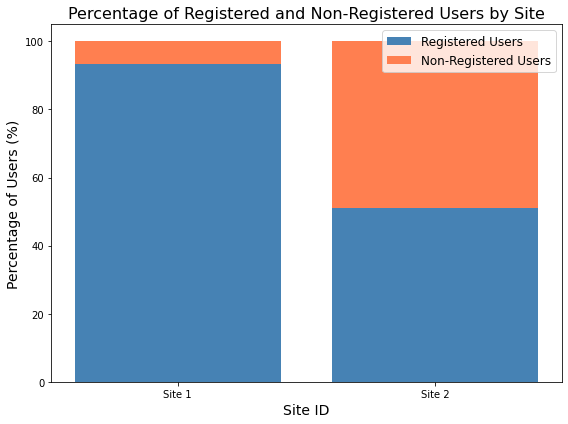

In [135]:

# filter for site 1 and site 2 
site_data = charging_set[charging_set['siteID'].isin([1, 2])]

# group by and count site id and is registered
site_user_counts = site_data.groupby(['siteID', 'isRegistered']).size().unstack(fill_value=0)

# calculate percentages
site_user_percentages = site_user_counts.div(site_user_counts.sum(axis=1), axis=0) * 100

# perpare data
site_ids = site_user_percentages.index
registered_percentages = site_user_percentages[1]  # Prozentual registrierte Benutzer
non_registered_percentages = site_user_percentages[0] if 0 in site_user_percentages.columns else [0] * len(site_ids)  # Prozentual nicht registrierte Benutzer

# create plot 
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(site_ids, registered_percentages, label='Registered Users', color='#4682B4')
ax.bar(site_ids, non_registered_percentages, bottom=registered_percentages, label='Non-Registered Users', color='#FF7F50')

# titles and lables 
ax.set_xlabel('Site ID', fontsize=14)
ax.set_ylabel('Percentage of Users (%)', fontsize=14)
ax.set_title('Percentage of Registered and Non-Registered Users by Site', fontsize=16)

# legend and ticks 
ax.set_xticks(site_ids)
ax.set_xticklabels([f'Site {int(site)}' for site in site_ids])
ax.legend(fontsize=12)

# plot 
plt.tight_layout()
plt.show()

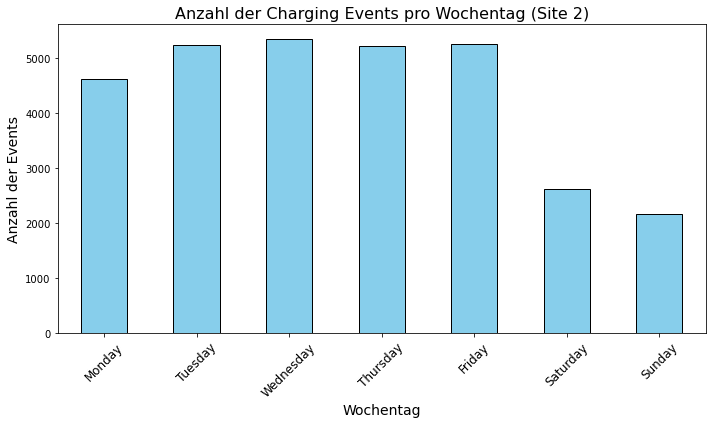

In [136]:
# only site 2
site_data = charging_set[charging_set['siteID'] == 2]

# convert to dt 
site_data['connection_date'] = pd.to_datetime(site_data['connectionTime'])

# extract weekday
site_data['weekday'] = site_data['connection_date'].dt.day_name()

# count charging events per weekday
weekday_counts = site_data['weekday'].value_counts()

# sort
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(weekday_order)

# create plot 
plt.figure(figsize=(10, 6))
weekday_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Anzahl der Charging Events pro Wochentag (Site 2)', fontsize=16)
plt.xlabel('Wochentag', fontsize=14)
plt.ylabel('Anzahl der Events', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# plot 
plt.show()


# New Visualization
After examining the development over the months, we also examine the development over the season, which are grouped by month and not by specific date.This should show no real surprises after having analyzed the distribution over the months but might still visualize new patterns that were hidden when just considering the months. 

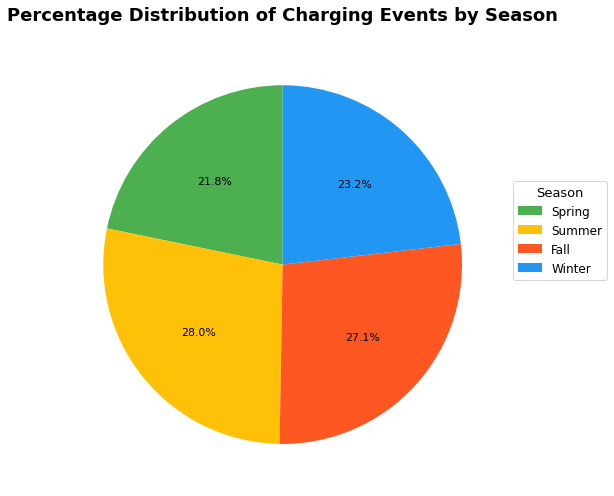

In [137]:
# aggregate data by month
events_per_month = charging_set.groupby(charging_set['connectionTime'].dt.month).size().reset_index(name='count')
events_per_month.rename(columns={'connectionTime': 'month'}, inplace=True)

# map months to seasons
def map_month_to_season(month):
    if month in [12, 1, 2]:  # Winter
        return 'Winter'
    elif month in [3, 4, 5]:  # Spring
        return 'Spring'
    elif month in [6, 7, 8]:  # Summer
        return 'Summer'
    elif month in [9, 10, 11]:  # Fall
        return 'Fall'

# add a "season" column
events_per_month['season'] = events_per_month['month'].apply(map_month_to_season)

# aggregate events by season
events_per_season = events_per_month.groupby('season')['count'].sum().reindex(['Spring', 'Summer', 'Fall', 'Winter'])

# colors for the seasons (with a professional look)
colors = ['#4CAF50', '#FFC107', '#FF5722', '#2196F3']  # Green, Yellow, Orange, Blue

# create pie chart
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(
    events_per_season,
    autopct=lambda pct: f'{pct:.1f}%',  # format percentages to 1 decimal place
    startangle=90,
    colors=colors,
    textprops={'fontsize': 11, 'color': 'black'}
)

# title
plt.title(
    'Percentage Distribution of Charging Events by Season',
    fontsize=18,
    weight='bold',
    pad=20
)

# legend
ax.legend(
    wedges,
    events_per_season.index,
    title="Season",
    loc="upper left",
    bbox_to_anchor=(1, 0.7),
    fontsize=12,
    title_fontsize=13
)

# remove default Y-axis label
plt.ylabel('')

# adjust layout for better spacing
plt.tight_layout()

# plot
plt.show()

## Oberservations
- No surprises
- Summer is the season which records the most charging events
- April is the season which records the fewest charging events

## Adjustment
Differentiate between sites to identify trends or patterns over the months which are site dependent

In [138]:
# aggregate monthly site information 
events_per_month = charging_set.groupby([charging_set['connectionTime'].dt.month, 'siteID']).size().reset_index(name='count')
events_per_month.rename(columns={'connectionTime': 'month'}, inplace=True)

# map month to season 
def map_month_to_season(month):
    if month in [12, 1, 2]:  # Winter
        return 'Winter'
    elif month in [3, 4, 5]:  # Spring
        return 'Spring'
    elif month in [6, 7, 8]:  # Summer
        return 'Summer'
    elif month in [9, 10, 11]:  # Fall
        return 'Fall'

# add season column 
events_per_month['season'] = events_per_month['month'].apply(map_month_to_season)

# aggregate events per site
events_per_season = events_per_month.groupby(['season', 'siteID'])['count'].sum().reset_index()
events_per_season['season'] = pd.Categorical(events_per_season['season'], categories=['Spring', 'Summer', 'Fall', 'Winter'], ordered=True)

# calculate charging events per season 
total_events_per_season = events_per_season.groupby('season', as_index=False)['count'].sum()

# ensure siteID is treated as a categorical variable
events_per_season['siteID'] = events_per_season['siteID'].astype(str)

# define custom colors for the sites
custom_colors = {
    "1": '#4682B4',  # Darker Blue for Site 1
    "2": '#00008B'   # Dark Blue for Site 2
}

# plot events per site with grouped bars
fig = px.bar(
    events_per_season, 
    x='season', 
    y='count', 
    color='siteID',
    title='Charging Events by Season (Grouped by Site)',
    labels={'season': 'Season', 'count': 'Number of Charging Events', 'siteID': 'Site'},
    color_discrete_map=custom_colors,
    barmode='group'
)

# add total events as an orange line
fig.add_trace(
    go.Scatter(
        x=total_events_per_season['season'], 
        y=total_events_per_season['count'], 
        mode='lines+markers', 
        name='Total Charging Events',
        line=dict(color='orange', width=2),
        connectgaps=False
    )
)

# adjust layout 
fig.update_layout(
    title_font_size=18,
    legend_title_text="Site",
    template="plotly_white",
    xaxis=dict(categoryorder='array', categoryarray=['Spring', 'Summer', 'Fall', 'Winter'])
)

# plot 
fig.show()

# KPIs:




## KPI 1 Utilization KPI



We want to calculate the concrete utilization of the respective charging sites. We do this by looking at the active minutes during every hour and dividing them by the max. possible minutes at each site (60 * number of spaces).
First we have to create a dataframe of every hour in the charging set, so we can 

### Calculating the Utilization

create df with every hour between the first charging event and the last for site 1

In [139]:
# convert to datetime
charging_set_site1 = charging_set[charging_set["siteID"]==1]
charging_set_site1.drop_duplicates()
charging_set_site1["connectionTime"] = pd.to_datetime(charging_set_site1["connectionTime"])
charging_set_site1["disconnectTime"] = pd.to_datetime(charging_set_site1["disconnectTime"])
# sort acsending
charging_set_site1 = charging_set_site1.sort_values(by='connectionTime').reset_index(drop=True)

# set min and max time 
min_time = charging_set_site1['connectionTime'].min().floor('H')
max_time = charging_set_site1['disconnectTime'].max().ceil('H')

# create df for every hour 
hours_df = pd.DataFrame({'hour': pd.date_range(start=min_time, end=max_time, freq='H')})
hours_df.head()

,hour
0,2018-09-05 11:00:00+00:00
1,2018-09-05 12:00:00+00:00
2,2018-09-05 13:00:00+00:00
3,2018-09-05 14:00:00+00:00
4,2018-09-05 15:00:00+00:00


do the same for site 2

In [140]:
# Combine date and time columns into single datetime columns
charging_set_site2 = charging_set[charging_set["siteID"]==2]
charging_set_site2.drop_duplicates()
charging_set_site2["connectionTime"] = pd.to_datetime(charging_set_site2["connectionTime"])
charging_set_site2["disconnectTime"] = pd.to_datetime(charging_set_site2["disconnectTime"])
# sort ascending
charging_set_site2 = charging_set_site2.sort_values(by='connectionTime').reset_index(drop=True)
# set min and max time 
min_time = charging_set_site2['connectionTime'].min().floor('H')
max_time = charging_set_site2['disconnectTime'].max().ceil('H')
# create df
hours_df2 = pd.DataFrame({'hour': pd.date_range(start=min_time, end=max_time, freq='H')})
hours_df2.head()

,hour
0,2018-04-25 11:00:00+00:00
1,2018-04-25 12:00:00+00:00
2,2018-04-25 13:00:00+00:00
3,2018-04-25 14:00:00+00:00
4,2018-04-25 15:00:00+00:00


Calculate utilization in the way mentioned before for site 1 

In [141]:


# Number of spaces (total available spaces site 1)
total_spaces = 52

# Function to calculate active session minutes for each hour
def calculate_utilization(hour, charging_set_site1, total_spaces):
    start_of_hour = hour
    end_of_hour = hour + pd.Timedelta(hours=1)
    
    # Filter sessions active during this hour
    active_sessions = charging_set_site1[
        (charging_set_site1['connectionTime'] < end_of_hour) & (charging_set_site1['disconnectTime'] > start_of_hour)
    ]
    
    # Calculate active minutes for each session
    active_minutes = 0
    for _, session in active_sessions.iterrows():
        session_start = max(session['connectionTime'], start_of_hour)
        session_end = min(session['disconnectTime'], end_of_hour)
        active_minutes += (session_end - session_start).total_seconds() / 60  # Convert to minutes
    
    # Utilization as a percentage
    possible_minutes = total_spaces * 60  # 60 minutes per hour per space
    utilization = active_minutes / possible_minutes if possible_minutes > 0 else 0
    return utilization


# Compute utilization column
hours_df['utilization'] = hours_df['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site1, total_spaces)
)



Site 2 calculations 

In [142]:
# number of spaces (total available spaces site 2)
total_spaces = 54

# function to calculate active session minutes for each hour
def calculate_utilization(hour, charging_set_site2, total_spaces):
    start_of_hour = hour
    end_of_hour = hour + pd.Timedelta(hours=1)
    
    # filter sessions active during this hour
    active_sessions = charging_set_site2[
        (charging_set_site2['connectionTime'] < end_of_hour) & (charging_set_site2['disconnectTime'] > start_of_hour)
    ]
    
    # calculate active minutes for each session
    active_minutes = 0
    for _, session in active_sessions.iterrows():
        session_start = max(session['connectionTime'], start_of_hour)
        session_end = min(session['disconnectTime'], end_of_hour)
        active_minutes += (session_end - session_start).total_seconds() / 60  # Convert to minutes
    
    # utilization as a percentage
    possible_minutes = total_spaces * 60  # 60 minutes per hour per space
    utilization = active_minutes / possible_minutes if possible_minutes > 0 else 0
    return utilization


# compute utilization column
hours_df2['utilization'] = hours_df2['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site2, total_spaces)
)



### Plot the Utilization KPI

Plot site 1

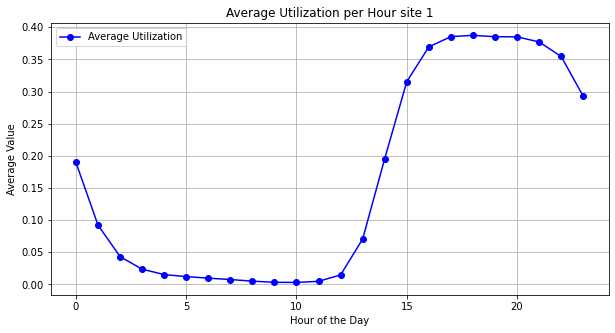

In [143]:
# extract the hour of the day (0-23)
hours_df["hour_of_day"] = hours_df["hour"].dt.hour

# group by hour and compute the mean (or sum)
df_aggregated = hours_df.groupby("hour_of_day").mean()

# plot the aggregated values
df_aggregated = hours_df.groupby("hour_of_day").mean()

# plot
plt.figure(figsize=(10, 5))
plt.plot(df_aggregated.index, df_aggregated["utilization"], marker="o", linestyle="-", label="Average Utilization", color="blue")

# labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Average Value")
plt.title("Average Utilization per Hour site 1")
plt.legend()
plt.grid(True)

# plot 
plt.show()

Plot site 2 

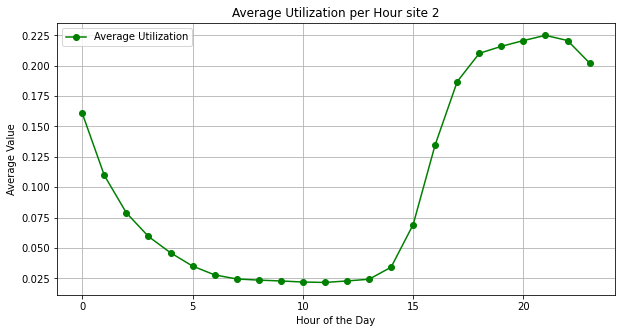

In [144]:
# extract the hour of the day (0-23)
hours_df2["hour_of_day"] = hours_df2["hour"].dt.hour

# group by hour and compute the mean (or sum)
df_aggregated = hours_df2.groupby("hour_of_day").mean()

# plot the aggregated values
df_aggregated = hours_df2.groupby("hour_of_day").mean()

# plot
plt.figure(figsize=(10, 5))
plt.plot(df_aggregated.index, df_aggregated["utilization"], marker="o", linestyle="-", label="Average Utilization", color="green")


# labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Average Value")
plt.title("Average Utilization per Hour site 2")
plt.legend()
plt.grid(True)

# plot 
plt.show()

Plot both sites in one graph

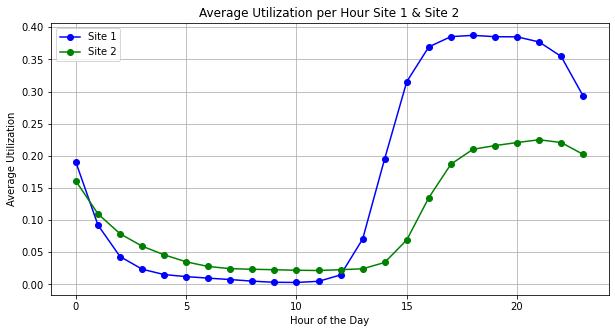

In [145]:

# extract the hour of the day (0-23)
hours_df["hour_of_day"] = hours_df["hour"].dt.hour
hours_df2["hour_of_day"] = hours_df2["hour"].dt.hour

# group by hour and compute the mean (or sum)
df_aggregated1 = hours_df.groupby("hour_of_day").mean()
df_aggregated2 = hours_df2.groupby("hour_of_day").mean()

# plot
plt.figure(figsize=(10, 5))

# plot site 1
plt.plot(df_aggregated1.index, df_aggregated1["utilization"], marker="o", linestyle="-", label="Site 1", color="blue")

# plot site 2
plt.plot(df_aggregated2.index, df_aggregated2["utilization"], marker="o", linestyle="-", label="Site 2", color="green")

# labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Average Utilization")
plt.title("Average Utilization per Hour Site 1 & Site 2")
plt.legend()
plt.grid(True)

# show plot
plt.show()


## KPI 2

In [146]:

# # ensure 'connectionTime', 'disconnectTime', and 'doneChargingTime' are datetime objects
# charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])
# charging_set['disconnectTime'] = pd.to_datetime(charging_set['disconnectTime'])
charging_set['doneChargingTime'] = pd.to_datetime(charging_set['doneChargingTime'])

# calculate total plugged-in time and actual charging time
charging_set['pluggedInMinutes'] = (charging_set['disconnectTime'] - charging_set['connectionTime']).dt.total_seconds() / 60
charging_set['chargingMinutes'] = (charging_set['doneChargingTime'] - charging_set['connectionTime']).dt.total_seconds() / 60

# ensure no negative times
charging_set['pluggedInMinutes'] = charging_set['pluggedInMinutes'].clip(lower=0)
charging_set['chargingMinutes'] = charging_set['chargingMinutes'].clip(lower=0)

# calculate idle time (plugged-in but not charging)
charging_set['idleMinutes'] = charging_set['pluggedInMinutes'] - charging_set['chargingMinutes']
charging_set['idleMinutes'] = charging_set['idleMinutes'].clip(lower=0)

# calculate the percentage of vehicles plugged in but not charging per hour
charging_set['hour'] = charging_set['connectionTime'].dt.hour
hourly_data = charging_set.groupby('hour').agg(
    totalPluggedInMinutes=('pluggedInMinutes', 'sum'),
    totalIdleMinutes=('idleMinutes', 'sum')
).reset_index()
hourly_data['percentIdle'] = (hourly_data['totalIdleMinutes'] / hourly_data['totalPluggedInMinutes']) * 100

# fill NaN values in percentIdle (caused by 0 totalPluggedInMinutes)
hourly_data['percentIdle'] = hourly_data['percentIdle'].fillna(0)

# visualize the percentage of vehicles plugged in but not charging per hour
fig = px.line(
    hourly_data,
    x='hour',
    y='percentIdle',
    title='Percentage of Vehicles Plugged In but Not Charging (%)',
    labels={'hour': 'Hour of the Day', 'percentIdle': 'Percentage Idle (%)'},
    template='plotly_white'
)

# show the plot
fig.show()

# print overall average percentage of idle vehicles
overall_avg_idle_percentage = hourly_data['percentIdle'].mean()
print(f"Overall Average Percentage of Vehicles Plugged In but Not Charging: {overall_avg_idle_percentage:.2f}%")

Overall Average Percentage of Vehicles Plugged In but Not Charging: 40.30%


# Observation
- The graph shows relatively high percentages of vehicles which are plugged in and are not charging
- The graph is also relatively volatile
- At 10:00 there is a siginifcant decrease, this probably aligns with people arriving at work with verhicles that are not fully charged

In [147]:

# # Ensure 'connectionTime', 'disconnectTime', and 'doneChargingTime' are datetime objects
# charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])
# charging_set['disconnectTime'] = pd.to_datetime(charging_set['disconnectTime'])
# charging_set['doneChargingTime'] = pd.to_datetime(charging_set['doneChargingTime'])

# calculate total plugged-in time and actual charging time
charging_set['pluggedInMinutes'] = (charging_set['disconnectTime'] - charging_set['connectionTime']).dt.total_seconds() / 60
charging_set['chargingMinutes'] = (charging_set['doneChargingTime'] - charging_set['connectionTime']).dt.total_seconds() / 60

# ensure no negative times
charging_set['pluggedInMinutes'] = charging_set['pluggedInMinutes'].clip(lower=0)
charging_set['chargingMinutes'] = charging_set['chargingMinutes'].clip(lower=0)

# calculate idle time (plugged-in but not charging)
charging_set['idleMinutes'] = charging_set['pluggedInMinutes'] - charging_set['chargingMinutes']
charging_set['idleMinutes'] = charging_set['idleMinutes'].clip(lower=0)

# calculate the percentage of vehicles plugged in but not charging per hour
charging_set['hour'] = charging_set['connectionTime'].dt.hour

# aggregation for all sites
hourly_data = charging_set.groupby('hour').agg(
    totalPluggedInMinutes=('pluggedInMinutes', 'sum'),
    totalIdleMinutes=('idleMinutes', 'sum')
).reset_index()
hourly_data['percentIdle'] = (hourly_data['totalIdleMinutes'] / hourly_data['totalPluggedInMinutes']) * 100
hourly_data['site'] = 'All Sites'

# aggregation for Site 1
hourly_data_site1 = charging_set[charging_set['siteID'] == 1].groupby('hour').agg(
    totalPluggedInMinutes=('pluggedInMinutes', 'sum'),
    totalIdleMinutes=('idleMinutes', 'sum')
).reset_index()
hourly_data_site1['percentIdle'] = (hourly_data_site1['totalIdleMinutes'] / hourly_data_site1['totalPluggedInMinutes']) * 100
hourly_data_site1['site'] = 'Site 1'

# aggregation for Site 2
hourly_data_site2 = charging_set[charging_set['siteID'] == 2].groupby('hour').agg(
    totalPluggedInMinutes=('pluggedInMinutes', 'sum'),
    totalIdleMinutes=('idleMinutes', 'sum')
).reset_index()
hourly_data_site2['percentIdle'] = (hourly_data_site2['totalIdleMinutes'] / hourly_data_site2['totalPluggedInMinutes']) * 100
hourly_data_site2['site'] = 'Site 2'

# combine data for visualization
combined_data = pd.concat([hourly_data, hourly_data_site1, hourly_data_site2], ignore_index=True)
combined_data['percentIdle'] = combined_data['percentIdle'].fillna(0)

# visualize the percentage of vehicles plugged in but not charging per hour for all sites
fig = px.line(
    combined_data,
    x='hour',
    y='percentIdle',
    color='site',
    title='Percentage of Vehicles Plugged In but Not Charging (%) by Site',
    labels={'hour': 'Hour of the Day', 'percentIdle': 'Percentage Idle (%)', 'site': 'Site'},
    template='plotly_white'
)

# show the plot
fig.show()

# print overall average percentage of idle vehicles for each site
for site in combined_data['site'].unique():
    avg_idle_percentage = combined_data[combined_data['site'] == site]['percentIdle'].mean()
    print(f"Overall Average Percentage of Vehicles Plugged In but Not Charging for {site}: {avg_idle_percentage:.2f}%")

Overall Average Percentage of Vehicles Plugged In but Not Charging for All Sites: 40.30%
Overall Average Percentage of Vehicles Plugged In but Not Charging for Site 1: 35.43%
Overall Average Percentage of Vehicles Plugged In but Not Charging for Site 2: 42.42%


# Obersvation
- This KPI now also differentiates between sites
- Site 2 has significantly higher percentage of vehicles nor charging 
- All Graphs are relatively volatile

## KPI 3. Energy Consumption
- shown below is the process of developing a third KPI
- The final KPI is located at the bottom



- Energy Delivered by Session (Mean)
- Energy Requested by Session (Mean)
- Energy Consumed by Hour
- Max Energy Delivered within a session
- By Sites for all registered Users --> Times payment was required

In [148]:
# # Filter for registered users (isRegistered == True)
# registered_users = charging_set[charging_set['isRegistered'] == 1]

# # Count how many registered users had to pay (paymentRequired == True)
# payment_required_count = registered_users[registered_users['paymentRequired'] == True].shape[0]

# # Count how many registered users did not have to pay (paymentRequired == -1)
# payment_not_required_count = registered_users[registered_users['paymentRequired'] == -1].shape[0]

# # Print the results
# print(f"Total registered users who had to pay: {payment_required_count}")
# print(f"Total registered users who did not have to pay: {payment_not_required_count}")


# New KPI proposition
This the energy KPI we actually employed and used for the report.


In [149]:
# extract hour
charging_set['hour'] = charging_set['connectionTime'].dt.hour

# aggregate total kWhDelivered per hour across all sites
hourly_total_kwh = charging_set.groupby('hour')['kWhDelivered'].sum().reset_index()

# aggregate total kWhDelivered per hour for Site 1
hourly_total_kwh_site1 = charging_set[charging_set['siteID'] == 1].groupby('hour')['kWhDelivered'].sum().reset_index()

# aggregate total kWhDelivered per hour for Site 2
hourly_total_kwh_site2 = charging_set[charging_set['siteID'] == 2].groupby('hour')['kWhDelivered'].sum().reset_index()

# create visualizations
fig_total = px.line(
    hourly_total_kwh,
    x='hour',
    y='kWhDelivered',
    title='Total kWh Delivered per Hour (All Sites)',
    labels={'hour': 'Hour of the Day', 'kWhDelivered': 'Total kWh Delivered'}
)

fig_site1 = px.line(
    hourly_total_kwh_site1,
    x='hour',
    y='kWhDelivered',
    title='Total kWh Delivered per Hour (Site 1)',
    labels={'hour': 'Hour of the Day', 'kWhDelivered': 'Total kWh Delivered'},
    color_discrete_sequence=['orange']
)

fig_site2 = px.line(
    hourly_total_kwh_site2,
    x='hour',
    y='kWhDelivered',
    title='Total kWh Delivered per Hour (Site 2)',
    labels={'hour': 'Hour of the Day', 'kWhDelivered': 'Total kWh Delivered'},
    color_discrete_sequence=['blue']
)

# show the graphs
fig_total.show()
fig_site1.show()
fig_site2.show()



# Adjustment
Combine all in one visualization

In [150]:
# extract hour
charging_set['hour'] = charging_set['connectionTime'].dt.hour

# aggregate total kWhDelivered per hour across all sites
hourly_total_kwh = charging_set.groupby('hour')['kWhDelivered'].sum().reset_index()
hourly_total_kwh['site'] = 'All Sites'

# aggregate total kWhDelivered per hour for Site 1
hourly_total_kwh_site1 = charging_set[charging_set['siteID'] == 1].groupby('hour')['kWhDelivered'].sum().reset_index()
hourly_total_kwh_site1['site'] = 'Site 1'

# aggregate total kWhDelivered per hour for Site 2
hourly_total_kwh_site2 = charging_set[charging_set['siteID'] == 2].groupby('hour')['kWhDelivered'].sum().reset_index()
hourly_total_kwh_site2['site'] = 'Site 2'

# combine all data
combined_data = pd.concat([hourly_total_kwh, hourly_total_kwh_site1, hourly_total_kwh_site2])

# define custom colors
color_map = {
    'All Sites': 'red',
    'Site 1': 'orange',
    'Site 2': 'green'
}

# create visualization
fig = px.line(
    combined_data,
    x='hour',
    y='kWhDelivered',
    color='site',
    title='Total kWh Delivered per Hour (All Sites, Site 1, and Site 2)',
    labels={'hour': 'Hour of the Day', 'kWhDelivered': 'Total kWh Delivered', 'site': 'Site'},
    color_discrete_map=color_map
)

fig.update_layout(
    title_font_size=18,
    xaxis=dict(
        title="Hour of the Day",
        tickmode='linear',
        dtick=1
    ),
    yaxis=dict(title="Total kWh Delivered"),
    template="plotly_white"
)

# plot 
fig.show()

# Observations
- Clear and significant peak at 14:00
- Abrupt fall after the narrow peak
- Site 2 Peaks later and lower around 15:00 to 17:00